<a href="https://colab.research.google.com/github/mrrajatgarg/my_project_works/blob/master/Genre_Classification_Using_End_To_End_2D_CNN_Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Information Retrieval (MIR)

**Defination --**

Music Information Retreval (MIR) is centered on finding ways to automate the process of classifying music genre and mood and tagging music.

**AIM:**

Given an audio clip of music, we have classify the audio clip into the genre it belongs to. Genres are - blues, classical, country, disco, hiphop, jaz, metal, pop, reggae, rock

# Importing Libraries

Importing numpy and os library

In [0]:
import os
import numpy as np
from os.path import join
import time

Importing Scikit Learn modules.


*   preprcossing - for the preprocessing of data
*   sklearn.metrics for calculating accuracy and ploting precision recall graph for better understanding of our results


*   train_test_split - for splitting of entire dataset into training(75%) and testing(25%) set.
*   StratifiedShuffleSplit - splitting of data into the desire manner (more will be clear from code itself)








In [0]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

Importing Layers and Optimizers from Keras (a high level deep learning framework)

In [0]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


librosa - widely used audio-processing library in python
kapre - Keras Audio Preprocessing library, from kapre Melspectrogram layer is imported

In [0]:
import librosa
import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

for plotting of different graphs for better visualization of results

In [0]:
!pip install scikit-plot
import matplotlib.pyplot as plt
%matplotlib inline 
import scikitplot as skplt

# Downloading and Visulizing Dataset

Downloading of GTZAN dataset which contains 1000 pieces of 30 sec audio-clips (ten genres and 100 songs for each genre).

In [0]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

--2019-01-28 18:28:09--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225573614 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G  1.57MB/s    in 12m 38s 

2019-01-28 18:40:48 (1.54 MB/s) - ‘genres.tar.gz’ saved [1225573614/1225573614]



Listing the root directory

In [0]:
!ls

genres.tar.gz  sample_data


Extracting the genres.tar.gz file in the root directory itself.

In [0]:
import tarfile

fname = 'genres.tar.gz'

tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

Visualizing the files inside the extracted data and getting back to root directory.

In [0]:
!ls

genres	genres.tar.gz  sample_data


In [0]:
cd genres

/content/genres


In [0]:
!ls

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [0]:
cd blues

/content/genres/blues


In [0]:
!ls

blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.au	blues.00052.au	blues.00072.au	blues.00092.au
blues.00013.au	blues.0003

In [0]:
cd /content/

/content


In [0]:
!ls

genres	genres.tar.gz  sample_data


# Data Preprocessing Step - Converting raw audio into numpy arrays

Defining the AUDIO_PATH as global variable.
classes_temp contains all the 10 types of genres in our training data

In [0]:
AUDIO_PATH = 'genres'
classes_temp = os.walk(AUDIO_PATH).__next__()[1]
print(classes_temp)

['classical', 'jazz', 'blues', 'rock', 'hiphop', 'disco', 'pop', 'reggae', 'country', 'metal']


This step may take time depending on your system specifications. I am using Google Colab which gives you free access to Nvidia Tesla K80 GPU and 12 GB of RAM. It took me around 32 minutes.

In this step, we are actually using librosa library to convert our raw audio data into numpy array's (wavedata stores the audio time series as a numpy array and sample rate stores the sampling rate of the audio (default sample rate is used here which is 22 Khz))

Moreover, we sample each audio into 10 audios of 2 seconds each (that is what the for loop over range(0, 20, 2) signifies).

Finally, list_data and classes information is stored in a .npy file list_data-offseti2-duration2.npy and classes-offseti2-duration2.npy respectivelly.

In [0]:
list_data = [] 
classes = [] 
load = None
savename = "offseti2-duration2.npy"

start = time.time()

for c in classes_temp:
  for root, subdirs, files in os.walk(os.path.join(AUDIO_PATH, c)):
    for file in files:
      for i in range(0, 20, 2):
        filepath = os.path.join(root, file)    
        wavedata, samplerate = librosa.load(filepath, sr=None, mono=True, offset=i, duration=2)    
        wavedata = wavedata[np.newaxis, :]
        list_data.append(wavedata)
        classes.append(c)

np.save("list_data-" + savename, list_data)
np.save("classes-" + savename, classes)
print(time.time() - start)

1958.2365872859955


Loading the stored data.

In [0]:
list_data = np.load("list_data-" + savename)
classes = np.load("classes-" + savename)

Visualizing the shape of list_data which is (10000, 1, 44100).
Here:

*   10000 - number of samples in the dataset (Remember, we divide each audio sample into 10 audio samples of 2 seconds each using librosa library)
*   (1, 44100) - dimension of each audio sample (44100 comes from the fact that the sampling rate is 22050 Hz (22050 datapoints each second)and each audio is 2 seconds long.)



In [0]:
list_data.shape

(10000, 1, 44100)

Steps for converting our 10 classes into one hot vector representation.

In [0]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
labelencoder.fit(classes)

n_classes = len(labelencoder.classes_)
print(n_classes, "classes:", ", ".join(list(labelencoder.classes_)))

classes_num = labelencoder.transform(classes)

10 classes: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock


In [0]:
classes_num_1hot = to_categorical(classes_num)
classes_num_1hot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [0]:
classes_num_1hot.shape

(10000, 10)

Converting list_data into a numpy array.

In [0]:
data = np.array(list_data)
data.shape

(10000, 1, 44100)

Splitting of dataset into training data (75%) and test data(25%) in the format so that we get 750 audio's from each category of genre in our training data and 250 audio's from each category of genre in our test data.

In [0]:
testset_size = 0.25
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes_num)

for train_index, test_index in splits:
    print("TRAIN INDEX:", train_index)
    print("TEST INDEX:", test_index)
    
    train_set = data[train_index]
    test_set = data[test_index]
    
    train_classes = classes_num[train_index]
    train_classes_1hot = classes_num_1hot[train_index]
    test_classes = classes_num[test_index]

print(train_set.shape)
print(test_set.shape)

TRAIN INDEX: [6083 1372 3713 ...  747  459 4636]
TEST INDEX: [5312 6983 4609 ...  742 1797 8974]
(7500, 1, 44100)
(2500, 1, 44100)


In [0]:
cnt = Counter(train_classes)
print("Number of files in each category in TRAIN set:")
for k in sorted(cnt.keys()):
    print(k, ":", cnt[k])

Number of files in each category in TRAIN set:
0 : 750
1 : 750
2 : 750
3 : 750
4 : 750
5 : 750
6 : 750
7 : 750
8 : 750
9 : 750


shape of train_set, test_set and input_shape of each audio sample.

In [0]:
train_set.shape

(7500, 1, 44100)

In [0]:
test_set.shape

(2500, 1, 44100)

In [0]:
input_shape = train_set.shape[1:]  
input_shape

(1, 44100)

# Defining our Deep Convolutional Neural Network (2D CNNs)

Defining our deep Convolutional Neural Network (2D CNNs). For more info on the model architecture see the model.summary() result.

In [0]:
np.random.seed(0)

model = Sequential()
model.add(Melspectrogram(n_dft=1024, n_hop=512, input_shape=input_shape, return_decibel_melgram=True, name='melgram'))
model.add(Normalization2D(str_axis='freq'))

# Layer 1
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 

# Layer 2
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 

model.add(Dense(100, activation='relu')) 
# model.add(BatchNormalization())
model.add(Dense(n_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['accuracy'])

history = None

Model architecture Visualization.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (Melspectrogram)     (None, 128, 87, 1)        1116288   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 128, 87, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 85, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 20, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19200)             0         
__________

Training of our Deep Convolutional Neural Network (CNN).
It may take time depending on your system specification. It took me around 6 seconds for each epoch on Google Colab.

In [0]:
modelName = "model1-conv2d"

History = model.fit(train_set, train_classes_1hot, validation_split=0.1, batch_size=32, epochs=10)

history = History.history
        
model.save(modelName + ".h5")
np.save(modelName + "-history.npy", history)

Train on 6750 samples, validate on 750 samples
Epoch 1/10
6750/6750 [==============================] - 21s 3ms/step - loss: 1.8288 - acc: 0.3527 - val_loss: 1.5411 - val_acc: 0.4827
Epoch 2/10
6750/6750 [==============================] - 6s 873us/step - loss: 1.4564 - acc: 0.4919 - val_loss: 1.4501 - val_acc: 0.4893
Epoch 3/10
6750/6750 [==============================] - 6s 870us/step - loss: 1.2089 - acc: 0.5803 - val_loss: 1.1901 - val_acc: 0.5920
Epoch 4/10
6750/6750 [==============================] - 6s 870us/step - loss: 1.0156 - acc: 0.6440 - val_loss: 1.1490 - val_acc: 0.5853
Epoch 5/10
6750/6750 [==============================] - 6s 866us/step - loss: 0.8863 - acc: 0.6944 - val_loss: 1.1436 - val_acc: 0.6027
Epoch 6/10
6750/6750 [==============================] - 6s 871us/step - loss: 0.7590 - acc: 0.7388 - val_loss: 0.9371 - val_acc: 0.6773
Epoch 7/10
6750/6750 [==============================] - 6s 864us/step - loss: 0.6516 - acc: 0.7764 - val_loss: 1.1677 - val_acc: 0.5893
Ep

Saving the model in model1-conv2d.h5 file.

In [0]:
model = keras.models.load_model(modelName + ".h5", custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                                       'Normalization2D': kapre.utils.Normalization2D})
history = np.load(modelName + "-history.npy").item()

int_axis=1 passed but is ignored, str_axis is used instead.


# Calculating Testing Accuracy and Visualizing the Results

Function for plotting of training accuracy, loss, validation accuracy and loss.

In [0]:
def plot_traincurve(history):
    colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")

    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

See the plot.

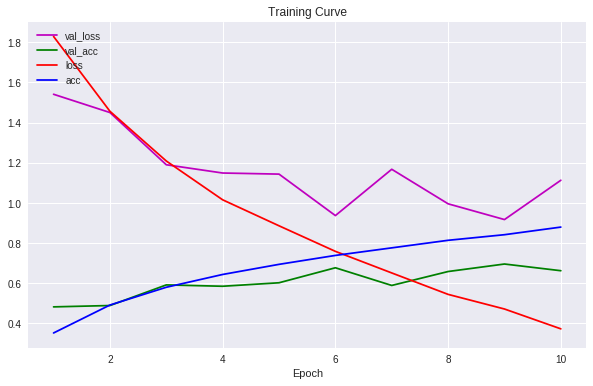

In [0]:
plot_traincurve(history)

Visualing the result on test_set by our trained model.

In [0]:
test_pred = model.predict_classes(test_set)
test_proba = model.predict_proba(test_set)
test_proba

array([[4.3355918e-05, 9.7532791e-01, 2.2469977e-02, ..., 1.7590440e-04,
        1.8088757e-04, 1.6978163e-05],
       [7.3132092e-01, 6.4084335e-04, 1.3367645e-01, ..., 3.4178861e-06,
        3.8191090e-05, 1.6416030e-03],
       [1.6245239e-03, 2.6945222e-07, 7.3879664e-07, ..., 7.0240800e-03,
        7.2375798e-01, 4.6925815e-03],
       ...,
       [1.9191949e-04, 1.1682238e-05, 1.5373597e-01, ..., 5.1000793e-02,
        1.3555899e-01, 6.4586401e-01],
       [6.3520134e-03, 2.4701196e-06, 6.9331646e-01, ..., 4.7952086e-03,
        4.6906702e-02, 2.3996894e-01],
       [3.7020334e-04, 7.7574306e-08, 1.3546649e-03, ..., 2.2864538e-06,
        3.6723322e-05, 8.8025862e-03]], dtype=float32)

Accuracy on the Genre Classification Task using 2D CNNs.

The accuracy is quite good as we have used a very small dataset of 7500 audio samples for training.

The accuracy can be increased by collecting more dataset (like using Free Music Archive (FMA) dataset as well) or twerking with model architecture as our current model has 1,930,678 trainable parameter which is quite large for such a small dataset.

In [0]:
accuracy_score(test_classes, test_pred)

0.686

Normalized Confusion Matrix - Have a look if you want to better understand our algorithm's results.

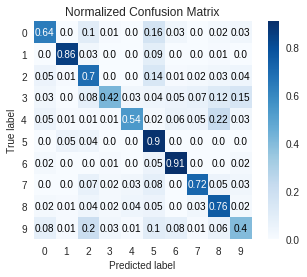

In [0]:
skplt.metrics.plot_confusion_matrix(test_classes, test_pred, normalize=True)

Precision - Recall Curve.

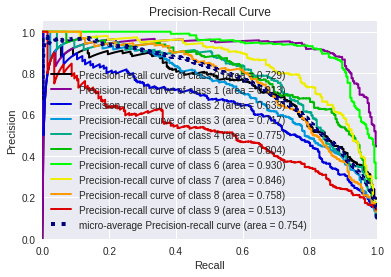

In [0]:
skplt.metrics.plot_precision_recall(test_classes, test_proba)